In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.linalg import toeplitz, svdvals

Provide equally spaced points centered about the origin. 

In [2]:
def grid(number_of_points, center): 
    return np.arange(-number_of_points / 2 + center, number_of_points / 2 + 1 + center)

t = grid(128, 0)

## Forward Direction

### Construct latent signal. 

In [3]:
latent_signal = np.piecewise(t, [t < -t.size / 6, t >= -t.size / 6, t >= t.size / 6], [0, 1, 0])

### Build Kernel Operator

In [4]:
def mixture_distribution(mixture_weights, components): 
    return mixture_weights @ components

def normal_distribution(t, mean, standard_deviation): 
    gaussian = np.exp(-0.5 * ((t - mean) / standard_deviation)**2)
    return gaussian / sum(gaussian)

def build_toeplitz(c, k): 
    n = c.size
    col = np.zeros_like(c)
    row = np.zeros_like(c)
    col[0:k+1] = c[k::1]
    row[0:k+1] = c[k::-1]
    return toeplitz(col, row)

weights = np.array([0.5, 0.5])
parametric_family = np.array([normal_distribution(t, 0, 10), normal_distribution(t, 0, 20)])
kernel = mixture_distribution(weights, parametric_family)
blurring_operator = build_toeplitz(kernel, kernel.size // 2)


### Blur Latent Signal & Add Noise

In [5]:
np.random.seed(1)

percentage = 0.05
noise = np.random.normal(0, latent_signal.std(), t.size) * percentage
data = blurring_operator @ latent_signal + noise

## Plotting. 

See [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html#examples-using-matplotlib-gridspec-gridspec) for more details. 

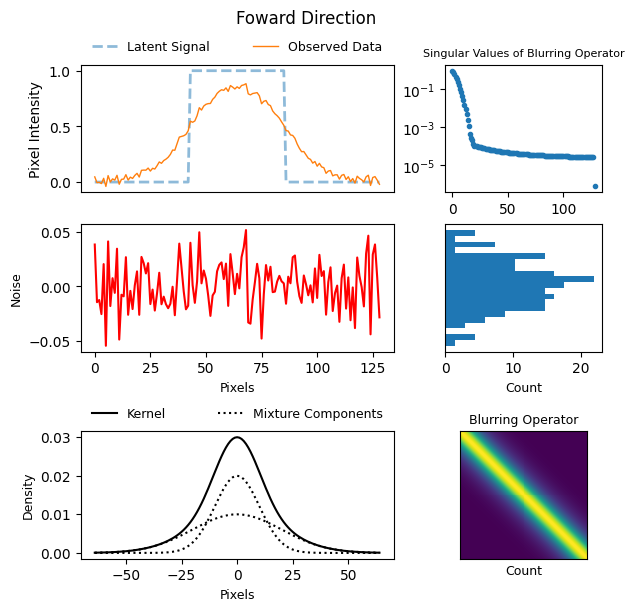

In [12]:
fig = plt.figure(layout="constrained",figsize=(6,6))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[-1, :2])
ax3 = fig.add_subplot(gs[1, :-1])
ax4 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1,2])
# ax3 = fig.add_subplot(gs[1:, -1])


ax6 = fig.add_subplot(gs[-1,2])

ax1.plot(t, latent_signal, '--', linewidth='2', alpha=0.5, label='Latent Signal')
ax1.plot(t, data, linewidth=1, label='Observed Data')
ax1.legend(bbox_to_anchor=(0,1,1,.1), ncol=2, mode='expand', loc='lower left', framealpha=0, fontsize=9)
ax1.set_ylabel('Pixel Intensity')
ax1.tick_params(bottom=False, labelbottom=False)

ax2.plot(t, kernel, 'k', label='Kernel')
ax2.plot(t, weights[0] * parametric_family[0], 'k:', label='Mixture Components')
ax2.plot(t, weights[1] * parametric_family[1], 'k:')
ax2.set_ylabel('Density', fontsize=9)
ax2.set_xlabel('Pixels', fontsize=9)
ax2.legend(bbox_to_anchor=(0,1,1,.1), ncol=2, mode='expand', loc='lower left', framealpha=0, fontsize=9)

ax3.plot(noise, 'r', label='Noise')
ax3.set_xlabel('Pixels', fontsize=9)
ax3.set_ylabel('Noise', fontsize=9)

ax4.semilogy(svdvals(blurring_operator), '.')
ax4.set_title('Singular Values of Blurring Operator', fontsize=8)

count, bins, ignored = ax5.hist(noise, 20, density=True, orientation='horizontal')
ax5.tick_params(labelleft=False, left=False)
ax5.set_xlabel('Count', fontsize=9)

ax6.matshow(blurring_operator)
ax6.set_title('Blurring Operator', fontsize=9)
ax6.tick_params(labeltop=False, labelleft=False, top=False, left=False, bottom=False)
ax6.set_xlabel('Count', fontsize=9)



fig.suptitle("Foward Direction")

plt.show()